In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os
import gc
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import zarr
import napari
from scipy.spatial import KDTree
from scipy.ndimage import rotate
import scipy.ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import torch.cuda.amp as amp  # ✅ Import automatic mixed precision (AMP)
import copy

gc.enable()

pd.options.display.max_columns = None
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'

In [3]:
train_data_experiment_folders_path = path + 'train/static/ExperimentRuns/'
train_data_experiment_folders_path

'/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static/ExperimentRuns/'

In [4]:
test_data_experiment_folders_path = path + 'test/static/ExperimentRuns/'
test_data_experiment_folders_path

'/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/test/static/ExperimentRuns/'

In [5]:
train_data_experiments = os.listdir(train_data_experiment_folders_path)
train_data_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

In [6]:
test_data_experiments = os.listdir(test_data_experiment_folders_path)
test_data_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4']

In [7]:
data_dict = {}
for experiment in tqdm(train_data_experiments):
    image_types_dict = {}    
    image_types_dict['denoised'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/denoised.zarr', mode='r')
    image_types_dict['iso'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/isonetcorrected.zarr', mode='r')
    image_types_dict['dcon'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/ctfdeconvolved.zarr', mode='r')
    image_types_dict['wbp'] = zarr.open(train_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/wbp.zarr', mode='r')
    data_dict[experiment] = image_types_dict

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 230.89it/s]


In [8]:
data_dict

{'TS_5_4': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_69_2': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_6_4': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_6_6': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierarchy.Group '/' read-only>},
 'TS_73_6': {'denoised': <zarr.hierarchy.Group '/' read-only>,
  'iso': <zarr.hierarchy.Group '/' read-only>,
  'dcon': <zarr.hierarchy.Group '/' read-only>,
  'wbp': <zarr.hierar

In [9]:
test_data_dict = {}
for experiment in tqdm(test_data_experiments):
    image_types_dict = {}    
    image_types_dict['denoised'] = zarr.open(test_data_experiment_folders_path + f'{experiment}/VoxelSpacing10.000/denoised.zarr', mode='r')
    test_data_dict[experiment] = image_types_dict

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3703.03it/s]


In [10]:
test_data_dict

{'TS_5_4': {'denoised': <zarr.hierarchy.Group '/' read-only>},
 'TS_69_2': {'denoised': <zarr.hierarchy.Group '/' read-only>},
 'TS_6_4': {'denoised': <zarr.hierarchy.Group '/' read-only>}}

In [11]:
train_label_experiment_folders_path = path + 'train/overlay/ExperimentRuns/'
train_label_experiment_folders_path

'/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

In [12]:
train_label_experiments = os.listdir(train_label_experiment_folders_path)
train_label_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

In [13]:
labels_dict = {}
for experiment in tqdm(train_label_experiments):
    particle_types_dict = {}
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/apo-ferritin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['apo-ferritin'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-amylase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-amylase'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-galactosidase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-galactosidase'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/ribosome.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['ribosome'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/thyroglobulin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['thyroglobulin'] = loaded_json

    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/virus-like-particle.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['virus-like-particle'] = loaded_json

    labels_dict[experiment] = particle_types_dict

100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 743.43it/s]


In [14]:
labels_dict

{'TS_5_4': {'apo-ferritin': {'pickable_object_name': 'apo-ferritin',
   'user_id': 'curation',
   'session_id': '0',
   'run_name': 'TS_5_4',
   'voxel_spacing': None,
   'unit': 'angstrom',
   'points': [{'location': {'x': 468.514, 'y': 5915.906, 'z': 604.167},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'instance_id': 0},
    {'location': {'x': 5674.694, 'y': 1114.354, 'z': 565.068},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'instance_id': 0},
    {'location': {'x': 5744.509, 'y': 1049.172, 'z': 653.712},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'instance_id': 0},
    {'location': {'x': 5880.769, 'y': 1125.348, 'z': 579.56},
     'transformation_': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      

In [15]:
particle_radius = {
    'apo-ferritin': 60,
    'beta-amylase': 65,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [16]:
class_ids = {
    'apo-ferritin': 0,
    'beta-amylase': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [17]:
weights_dict = {
    'apo-ferritin': 1,
    'beta-amylase': 0,
    'beta-galactosidase': 2,
    'ribosome': 1,
    'thyroglobulin': 2,
    'virus-like-particle': 1,
}

In [18]:
weights_list = [1, 0, 2, 1, 2, 1]  # Order must match class indices
class_weights = torch.tensor(weights_list, dtype=torch.float32).to('cuda')

In [19]:
experiment_list = []
particle_type_list = []
x_list = []
y_list = []
z_list = []
r_list = []
class_id_list = []
for experiment in tqdm(train_data_experiments):
    #print(experiment)
    #print(len(labels_dict[experiment]['apo-ferritin']['points']))
    #print(type(labels_dict[experiment]['apo-ferritin']['points']))
    #print(labels_dict[experiment]['apo-ferritin']['points'][0])

    for key in labels_dict[experiment].keys():
        #print(labels_dict[experiment][key])
        #print(labels_dict[experiment][key]['pickable_object_name'])
        for i in range(len(labels_dict[experiment][key]['points'])):
            experiment_list.append(labels_dict[experiment][key]['run_name'])
            particle_type_list.append(labels_dict[experiment][key]['pickable_object_name'])
            x_list.append(labels_dict[experiment][key]['points'][i]['location']['x']/10.012444537618887)
            y_list.append(labels_dict[experiment][key]['points'][i]['location']['y']/10.012444196428572)
            z_list.append(labels_dict[experiment][key]['points'][i]['location']['z']/10.012444196428572)
            r_list.append(particle_radius[key]/10)
            class_id_list.append(class_ids[key])

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 4988.13it/s]


In [20]:
labels_df = pd.DataFrame({'experiment':experiment_list, 'particle_type':particle_type_list, 'x':x_list, 'y':y_list, 'z':z_list, 'r':r_list, 'class_id':class_id_list})

In [21]:
for k, v in class_ids.items():
    labels_df['class_id_' + str(v)] = (labels_df['class_id'] == v).astype(int)
labels_df = labels_df.drop(columns=['class_id'])
print(labels_df.shape)
labels_df

(1269, 12)


experiment        particle_type           x           y           z  \
0        TS_5_4         apo-ferritin   46.793168  590.855328   60.341610   
1        TS_5_4         apo-ferritin  566.764088  111.296900   56.436569   
2        TS_5_4         apo-ferritin  573.736911  104.786801   65.289952   
3        TS_5_4         apo-ferritin  587.345975  112.394934   57.883968   
4        TS_5_4         apo-ferritin  465.587298  126.791918   80.940176   
...         ...                  ...         ...         ...         ...   
1264    TS_99_9  virus-like-particle  200.755769  474.671110  105.576419   
1265    TS_99_9  virus-like-particle  224.127883  430.470614   95.835540   
1266    TS_99_9  virus-like-particle   80.327037  580.990504   57.877276   
1267    TS_99_9  virus-like-particle  419.300999  552.769922   85.710240   
1268    TS_99_9  virus-like-particle  569.145525  332.728646   80.500024   

         r  class_id_0  class_id_1  class_id_2  class_id_3  class_id_4  \
0      6.0           1           0           0           0           0   
1      6.0           1           0           0           0           0   
2      6.0           1           0           0           0           0   
3      6.0           1           0           0           0           0   
4      6.0           1           0           0           0           0   
...    ...         ...         ...         ...         ...         ...   
1264  13.5           0           0           0           0           0   
1265  13.5           0           0           0           0           0   
1266  13.5           0           0           0           0           0   
1267  13.5           0           0           0           0           0   
1268  13.5           0           0           0           0           0   

      class_id_5  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
1264           1  
1265           1  
1266           1  
1267           1  
1268           1  

[1269 rows x 12 columns]

In [22]:
labels_df.to_csv(path + 'labels.csv', index=False)

In [23]:
labels_df['experiment'].unique()

array(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9'], dtype=object)

In [24]:
labels_df['experiment'].nunique()

7

In [25]:
labels_df['particle_type'].unique()

array(['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome',
       'thyroglobulin', 'virus-like-particle'], dtype=object)

In [26]:
labels_df['particle_type'].nunique()

6

In [27]:
train_experiments = list(data_dict.keys())[:5]
train_experiments

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6']

In [28]:
valid_experiments = list(data_dict.keys())[5:]
valid_experiments

['TS_86_3', 'TS_99_9']

In [29]:
data_dict[train_experiments[0]].keys()

dict_keys(['denoised', 'iso', 'dcon', 'wbp'])

In [30]:
train_labels_df = labels_df[labels_df['experiment'].isin(train_experiments)].reset_index(drop=True).reset_index().rename(columns={'index':'id'})
train_labels_df

id experiment        particle_type           x           y           z  \
0      0     TS_5_4         apo-ferritin   46.793168  590.855328   60.341610   
1      1     TS_5_4         apo-ferritin  566.764088  111.296900   56.436569   
2      2     TS_5_4         apo-ferritin  573.736911  104.786801   65.289952   
3      3     TS_5_4         apo-ferritin  587.345975  112.394934   57.883968   
4      4     TS_5_4         apo-ferritin  465.587298  126.791918   80.940176   
..   ...        ...                  ...         ...         ...         ...   
831  831    TS_73_6  virus-like-particle  143.425114  136.687004   98.855083   
832  832    TS_73_6  virus-like-particle  163.488346  379.418244  100.482458   
833  833    TS_73_6  virus-like-particle  329.477680  455.472501   51.500012   
834  834    TS_73_6  virus-like-particle  308.926855  472.322433   64.500035   
835  835    TS_73_6  virus-like-particle  333.911762  471.701306   73.500035   

        r  class_id_0  class_id_1  class_id_2  class_id_3  class_id_4  \
0     6.0           1           0           0           0           0   
1     6.0           1           0           0           0           0   
2     6.0           1           0           0           0           0   
3     6.0           1           0           0           0           0   
4     6.0           1           0           0           0           0   
..    ...         ...         ...         ...         ...         ...   
831  13.5           0           0           0           0           0   
832  13.5           0           0           0           0           0   
833  13.5           0           0           0           0           0   
834  13.5           0           0           0           0           0   
835  13.5           0           0           0           0           0   

     class_id_5  
0             0  
1             0  
2             0  
3             0  
4             0  
..          ...  
831           1  
832           1  
833           1  
834           1  
835           1  

[836 rows x 13 columns]

In [31]:
valid_labels_df = labels_df[labels_df['experiment'].isin(valid_experiments)].reset_index(drop=True).reset_index().rename(columns={'index':'id'})
valid_labels_df

id experiment        particle_type           x           y           z  \
0      0    TS_86_3         apo-ferritin  386.553252  494.655841  126.003199   
1      1    TS_86_3         apo-ferritin  412.576268  541.555278   50.123625   
2      2    TS_86_3         apo-ferritin  273.160065  466.264471   51.964434   
3      3    TS_86_3         apo-ferritin  264.632177  468.478516   60.017613   
4      4    TS_86_3         apo-ferritin  266.204021  480.466198   61.125834   
..   ...        ...                  ...         ...         ...         ...   
428  428    TS_99_9  virus-like-particle  200.755769  474.671110  105.576419   
429  429    TS_99_9  virus-like-particle  224.127883  430.470614   95.835540   
430  430    TS_99_9  virus-like-particle   80.327037  580.990504   57.877276   
431  431    TS_99_9  virus-like-particle  419.300999  552.769922   85.710240   
432  432    TS_99_9  virus-like-particle  569.145525  332.728646   80.500024   

        r  class_id_0  class_id_1  class_id_2  class_id_3  class_id_4  \
0     6.0           1           0           0           0           0   
1     6.0           1           0           0           0           0   
2     6.0           1           0           0           0           0   
3     6.0           1           0           0           0           0   
4     6.0           1           0           0           0           0   
..    ...         ...         ...         ...         ...         ...   
428  13.5           0           0           0           0           0   
429  13.5           0           0           0           0           0   
430  13.5           0           0           0           0           0   
431  13.5           0           0           0           0           0   
432  13.5           0           0           0           0           0   

     class_id_5  
0             0  
1             0  
2             0  
3             0  
4             0  
..          ...  
428           1  
429           1  
430           1  
431           1  
432           1  

[433 rows x 13 columns]

In [32]:
data_dict['TS_5_4']['denoised'][0].shape

(184, 630, 630)

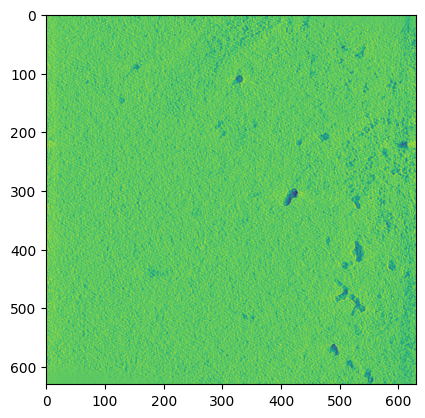

In [33]:
plt.imshow(data_dict['TS_5_4']['denoised'][0][0])

In [34]:
1 <= 2 <= 3

True

In [35]:
valid_labels_df

id experiment        particle_type           x           y           z  \
0      0    TS_86_3         apo-ferritin  386.553252  494.655841  126.003199   
1      1    TS_86_3         apo-ferritin  412.576268  541.555278   50.123625   
2      2    TS_86_3         apo-ferritin  273.160065  466.264471   51.964434   
3      3    TS_86_3         apo-ferritin  264.632177  468.478516   60.017613   
4      4    TS_86_3         apo-ferritin  266.204021  480.466198   61.125834   
..   ...        ...                  ...         ...         ...         ...   
428  428    TS_99_9  virus-like-particle  200.755769  474.671110  105.576419   
429  429    TS_99_9  virus-like-particle  224.127883  430.470614   95.835540   
430  430    TS_99_9  virus-like-particle   80.327037  580.990504   57.877276   
431  431    TS_99_9  virus-like-particle  419.300999  552.769922   85.710240   
432  432    TS_99_9  virus-like-particle  569.145525  332.728646   80.500024   

        r  class_id_0  class_id_1  class_id_2  class_id_3  class_id_4  \
0     6.0           1           0           0           0           0   
1     6.0           1           0           0           0           0   
2     6.0           1           0           0           0           0   
3     6.0           1           0           0           0           0   
4     6.0           1           0           0           0           0   
..    ...         ...         ...         ...         ...         ...   
428  13.5           0           0           0           0           0   
429  13.5           0           0           0           0           0   
430  13.5           0           0           0           0           0   
431  13.5           0           0           0           0           0   
432  13.5           0           0           0           0           0   

     class_id_5  
0             0  
1             0  
2             0  
3             0  
4             0  
..          ...  
428           1  
429           1  
430           1  
431           1  
432           1  

[433 rows x 13 columns]

In [36]:
a = torch.ones(0, 300)
b = torch.ones(2, 300)
c = torch.ones(19, 300)
d = torch.ones(19, 300)
test_pad = pad_sequence([a, b, c, d])
test_pad.size()

torch.Size([19, 4, 300])

In [37]:
class DataAugmentation3D:
    def __init__(self, flip=True, rotate=True, gaussian_noise=True, intensity_scaling=True, elastic_deform=True):
        self.flip = flip
        self.rotate = rotate
        self.gaussian_noise = gaussian_noise
        self.intensity_scaling = intensity_scaling
        self.elastic_deform = elastic_deform
        self.alpha = 15
        self.sigma = 3

    def __call__(self, image, labels):
        """
        Apply random 3D data augmentation.
        :param image: 3D numpy array (D, H, W)
        :param labels: Tensor containing bounding spheres (N, 4 + num_classes)
        :return: Augmented image and labels
        """
        if self.flip and random.random() > 0.5:
            image, labels = self.random_flip(image, labels)

        if self.rotate and random.random() > 0.5:
            image, labels = self.random_rotation(image, labels)

        if self.gaussian_noise and random.random() > 0.5:
            image = self.add_gaussian_noise(image)

        if self.intensity_scaling and random.random() > 0.5:
            image = self.scale_intensity(image)

        if self.elastic_deform and random.random() > 0.5:
            image = self.elastic_deformation(image)

        return image, labels

    def random_flip(self, image, labels):
        """ Randomly flip along one or more axes """
        axis = random.choice([0, 1, 2])  # Select a random axis
        image = np.flip(image, axis=axis).copy()

        # Flip bounding spheres accordingly
        labels[:, axis] = image.shape[axis] - labels[:, axis]
        return image, labels

    def random_rotation(self, image, labels):
        """ Apply random 90-degree rotation along a random axis """
        axes = random.choice([(0, 1), (1, 2), (0, 2)])
        k = random.choice([1, 2, 3])  # Rotate 90, 180, or 270 degrees

        image = np.rot90(image, k=k, axes=axes).copy()

        # Rotate bounding spheres
        labels[:, [axes[0], axes[1]]] = labels[:, [axes[1], axes[0]]]
        return image, labels

    def add_gaussian_noise(self, image, mean=0, std=0.01):
        """ Add Gaussian noise to the image """
        noise = np.random.normal(mean, std, image.shape)
        return np.clip(image + noise, 0, 1)  # Keep values between 0-1

    def scale_intensity(self, image, min_scale=0.8, max_scale=1.2):
        """ Scale the intensity of the image randomly """
        scale_factor = random.uniform(min_scale, max_scale)
        return np.clip(image * scale_factor, 0, 1)

    def elastic_deformation(self, image, alpha=15, sigma=3):
        """Apply elastic deformation to a 3D image."""
        if image.ndim != 3:  
            raise ValueError(f"Expected image shape (D, H, W), got {image.shape}")
    
        shape = image.shape  # (D, H, W)
        random_state = np.random.RandomState(None)
    
        # Generate random displacement fields
        dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
        dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
        dz = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    
        # Create meshgrid for indexing
        z, y, x = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    
        # Compute new indices with deformation
        indices = (
            np.clip(z + dz, 0, shape[0] - 1).astype(np.float32),
            np.clip(y + dy, 0, shape[1] - 1).astype(np.float32),
            np.clip(x + dx, 0, shape[2] - 1).astype(np.float32),
        )
    
        # Apply deformation
        return scipy.ndimage.map_coordinates(image, indices, order=1, mode="nearest").reshape(shape)

In [38]:
class YOLO3DDataset_Multi(Dataset):
    def __init__(self, dataset_labels_df, crop_size=(64, 128, 128), stride=(32, 64, 64), transform=None, augment=False):
        self.dataset_labels_df = dataset_labels_df.copy()
        self.crop_size = crop_size
        self.stride = stride
        self.augment = augment
        self.transform = DataAugmentation3D() if augment else None
        
        self.patches = []
        self.patch_bboxes = []
        self.patch_experiment_ids = []
        self.patch_offsets = []  # ✅ Initialize offsets

        self.process_all_images()

    def process_all_images(self):
        """ Process all images and extract patches with corresponding bounding spheres. """
        
        i = 0        
        for experiment in tqdm(self.dataset_labels_df['experiment'].unique()):
            for v in data_dict[experiment].keys():
                image = data_dict[experiment][v]['0']

                # ✅ Ensure consistent normalization
                #image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
                image = image - np.min(image)
                image = image / np.max(image)

                image_labels = self.dataset_labels_df[self.dataset_labels_df['experiment'] == experiment].drop(columns=['id']).to_numpy()

                patches, bboxes, offsets = self.create_crops_with_labels(image, image_labels)
                self.patches.extend(patches)
                self.patch_bboxes.extend(bboxes)
                self.patch_experiment_ids.extend([experiment] * len(patches))
                self.patch_offsets.extend(offsets)
                
                i += 1
                
        print(f"✅ Processed {i} images into {len(self.patches)} patches.")

    def create_crops_with_labels(self, image, labels):
        """ Extract overlapping 3D patches and assign bounding spheres to them efficiently. """
        d, h, w = image.shape
        crops, bboxes, offsets = [], [], []
    
        crop_size = self.crop_size
        stride = self.stride

        padding_value = -1 #np.mean(image)  # Use mean intensity for padding

        for z in range(0, d - stride[0], stride[0]):  
            for y in range(0, h - stride[1], stride[1]):  
                for x in range(0, w - stride[2], stride[2]):
                    
                    # ✅ Extract cropped patch
                    cropped_patch = image[z:z+crop_size[0], y:y+crop_size[1], x:x+crop_size[2]]

                    # ✅ Apply padding if necessary
                    if cropped_patch.shape != (64, 128, 128):
                        padded_image = np.full((64, 128, 128), padding_value, dtype=image.dtype)
                        padded_image[:cropped_patch.shape[0], :cropped_patch.shape[1], :cropped_patch.shape[2]] = cropped_patch
                        cropped_patch = padded_image.copy()
                        
                    cropped_bboxes = []
    
                    # ✅ Find bounding spheres within this patch (considering partial overlap)
                    for bbox in labels:
                        exp_id, particle_name, x_center, y_center, z_center, radius, *class_vector = bbox

                        # ✅ Compute the nearest stride-aligned grid position
                        z_grid = (z_center // stride[0]) * stride[0]
                        y_grid = (y_center // stride[1]) * stride[1]
                        x_grid = (x_center // stride[2]) * stride[2]
                        
                        # ✅ Assign bounding sphere only once to the closest aligned grid patch
                        #if (z == z_grid and y == y_grid and x == x_grid):
                        if (abs(z_grid - z) < stride[0] and abs(y_grid - y) < stride[1] and abs(x_grid - x) < stride[2]):
                            z_new = z_center - z
                            y_new = y_center - y
                            x_new = x_center - x
                            cropped_bboxes.append([z_new, y_new, x_new, radius] + class_vector)
    
                    # ✅ Append patches and bounding spheres
                    crops.append(torch.tensor(cropped_patch, dtype=torch.float32))
                    bboxes.append(torch.tensor(cropped_bboxes, dtype=torch.float32) if cropped_bboxes else torch.empty((0, 4 + 6)))
                    offsets.append([z, y, x])  # ✅ Store offset for each patch
    
        # ✅ Stack patches into a single tensor for efficient storage
        crops_tensor = torch.stack(crops)
    
        # ✅ Pad bounding sphere tensors for batch consistency
        bboxes_tensor = pad_sequence(bboxes, batch_first=True, padding_value=-1)

        #print(bboxes_tensor.shape)

        offsets_tensor = torch.tensor(offsets, dtype=torch.float32)
    
        return crops_tensor, bboxes_tensor, offsets_tensor

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        x = self.patches[idx]  # Shape: (64, 128, 128)
        y = self.patch_bboxes[idx]
        experiment_id = self.patch_experiment_ids[idx]
        crop_offset = self.patch_offsets[idx]
    
        # ✅ Ensure image is in (D, H, W) format before augmentation
        if x.ndim == 4 and x.shape[0] == 1:  
            x = x.squeeze(0)  # Remove the channel dimension if it exists
    
        # ✅ Apply Data Augmentation if Enabled
        if self.augment and self.transform:
            x, y = self.transform(x.numpy(), y)  # Convert to numpy for augmentation
            x = torch.tensor(x, dtype=torch.float32)  # Convert back to tensor
    
        # ✅ Restore (1, D, H, W) format before returning
        return x.unsqueeze(0), y, experiment_id, crop_offset

In [39]:
# ✅ Example Usage
train_dataset = YOLO3DDataset_Multi(train_labels_df, augment=True)

100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]

✅ Processed 20 images into 8100 patches.


In [40]:
valid_dataset = YOLO3DDataset_Multi(valid_labels_df)

100%|█████████████████████████████████████████████| 2/2 [00:11<00:00,  5.55s/it]

✅ Processed 8 images into 3240 patches.


In [41]:
def collate_fn(batch):
    images, targets, experiment_ids, crop_offsets = zip(*batch)

    # 🔹 Find the maximum depth, height, and width across the batch
    max_d = max(img.shape[1] for img in images)  # Depth
    max_h = max(img.shape[2] for img in images)  # Height
    max_w = max(img.shape[3] for img in images)  # Width

    # 🔹 Pad images to the largest shape in the batch
    padded_images = []
    for img in images:
        d, h, w = img.shape[1:]  # Extract original shape
        pad_img = torch.full((1, max_d, max_h, max_w), fill_value=-1.0, dtype=img.dtype)
        pad_img[:, :d, :h, :w] = img  # Copy original data
        padded_images.append(pad_img)

    images = torch.stack(padded_images, dim=0)  # Stack into batch tensor

    # 🔹 Handle bounding box padding
    max_boxes = max(target.shape[0] for target in targets)  # Find max anchor count
    padded_targets = torch.full((len(targets), max_boxes, 10), -1.0)  # Use -1 as padding
    for i, target in enumerate(targets):
        padded_targets[i, :target.shape[0], :] = target  # Copy values

    # ✅ **Fix: Ensure `crop_offsets` are stacked properly**
    if isinstance(crop_offsets[0], torch.Tensor):
        crop_offsets_tensor = torch.stack(crop_offsets)  # Already tensors, just stack
    else:
        crop_offsets_tensor = torch.tensor(crop_offsets, dtype=torch.float32)  # Convert list to tensor

    return images, padded_targets, list(experiment_ids), crop_offsets_tensor

In [42]:
def count_anchors_in_patch(targets):
    """
    Counts the number of valid bounding spheres (anchors) per cropped image.
    Only considers valid targets where x != -1.
    """
    num_anchors = (targets[..., 0] != -1).sum().item()  # Count valid bounding spheres
    return num_anchors

In [43]:
def find_max_anchors_dataloader(dataset, batch_size=8, num_workers=4):
    """
    Finds the maximum number of anchors per cropped image in the dataset.
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    max_anchors = 0
    for batch in tqdm(dataloader, total=len(dataloader)):
        _, targets, _, _ = batch  # Unpack batch
        for i in range(targets.shape[0]):  # Iterate over cropped images in batch
            num_anchors = count_anchors_in_patch(targets[i])  # Count per patch
            max_anchors = max(max_anchors, num_anchors)  # Track highest per patch

    return max_anchors

In [44]:
max_anchors = find_max_anchors_dataloader(train_dataset, batch_size=32, num_workers=6)
print(f"Optimal Number of Anchors per Cropped Image: {max_anchors}")

100%|█████████████████████████████████████████| 254/254 [03:05<00:00,  1.37it/s]

Optimal Number of Anchors per Cropped Image: 15


In [ ]:
class YOLO3D_Custom(nn.Module):
    def __init__(self, num_classes=6, num_anchors=5):
        super(YOLO3D_Custom, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        # 🔹 **Custom 3D CNN Backbone**
        self.backbone = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),  # [B, 32, 32, 64, 64]
            nn.BatchNorm3d(32),
            nn.ReLU(),

            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # [B, 64, 16, 32, 32]
            nn.BatchNorm3d(64),
            nn.ReLU(),

            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),  # [B, 128, 8, 16, 16]
            nn.BatchNorm3d(128),
            nn.ReLU(),

            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),  # [B, 256, 4, 8, 8]
            nn.BatchNorm3d(256),
            nn.ReLU(),

            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),  # [B, 512, 2, 4, 4]
            nn.BatchNorm3d(512),
            nn.ReLU()
        )

        # 🔹 **Adaptive Pooling for Fixed Feature Map Size**
        self.adaptive_pool = nn.AdaptiveAvgPool3d((2, 4, 4))  # Ensure a fixed output shape

        # 🔹 **1x1x1 Conv to Reduce Depth**
        self.conv1x1x1 = nn.Sequential(
            nn.Conv3d(512, 64, kernel_size=1),
            nn.BatchNorm3d(64),
            nn.ReLU()
        )

        # 🔹 **Fully Connected Layer**
        self.flattened_feature_size = 64 * 2 * 4 * 4  # (Depth × Height × Width)
        self.fc = nn.Linear(self.flattened_feature_size, self.num_anchors * (4 + self.num_classes))

    def forward(self, x):
        x = self.backbone(x)  # Feature extraction
        x = self.adaptive_pool(x)  # Fix output size
        x = self.conv1x1x1(x)  # Reduce depth

        x = x.view(x.shape[0], -1)  # Flatten
        
        # 🔹 **Dynamically adjust FC layer if needed**
        if x.shape[1] != self.fc.in_features:
            print(f"⚠️ Updating FC layer: New Input Size {x.shape[1]} (Old: {self.fc.in_features})")
            self.fc = nn.Linear(x.shape[1], self.num_anchors * (4 + self.num_classes)).to(x.device)

        x = self.fc(x)

        batch_size = x.shape[0]
        x = x.view(batch_size, self.num_anchors, 4 + self.num_classes)

        x_class = torch.softmax(x[..., 4:], dim=-1)
        x = torch.cat([x[..., :4], x_class], dim=-1)

        return x

In [45]:
class YOLO3D_Custom(nn.Module):
    def __init__(self, num_classes=6, num_anchors=5):
        super(YOLO3D_Custom, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.backbone = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, 32),  # ✅ GroupNorm instead of BatchNorm
            nn.ReLU(),

            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(),

            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU(),

            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, 256),
            nn.ReLU(),

            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(8, 512),
            nn.ReLU()
        )

        self.adaptive_pool = nn.AdaptiveAvgPool3d((2, 4, 4))

        self.conv1x1x1 = nn.Sequential(
            nn.Conv3d(512, 64, kernel_size=1),
            nn.GroupNorm(8, 64),
            nn.ReLU()
        )

        self.fc = nn.Linear(64 * 2 * 4 * 4, self.num_anchors * (4 + self.num_classes))

    def forward(self, x):
        x = self.backbone(x)
        x = self.adaptive_pool(x)
        x = self.conv1x1x1(x)
        x = x.view(x.shape[0], -1)  # Flatten

        x = self.fc(x)
        batch_size = x.shape[0]
        x = x.view(batch_size, self.num_anchors, 4 + self.num_classes)

        x_class = torch.softmax(x[..., 4:], dim=-1)
        x = torch.cat([x[..., :4], x_class], dim=-1)

        return x

In [46]:
model = YOLO3D_Custom(num_anchors=max_anchors)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, predictions, targets):
        """Compute focal loss across all anchors."""

        # ✅ Adjust for Multiple Anchors: Shape (batch_size, num_anchors, 4 + num_classes)
        pred_cls = predictions[..., 4:].clone()  # Extract class predictions
        target_cls = targets[..., 4:].clone()  # Extract target class labels

        pred_cls = torch.clamp(pred_cls, min=-20, max=20)  # Prevent instability
        target_cls = torch.clamp(target_cls, min=0, max=1)

        ce_loss = F.binary_cross_entropy_with_logits(pred_cls, target_cls, reduction="none")

        # Compute focal weight
        p_t = torch.exp(-ce_loss)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss

        # 🔹 Reduce Focal Loss weight to allow learning
        focal_loss *= 0.5  

        # ✅ Average across anchors
        focal_loss = focal_loss.mean(dim=1)  # Average over `num_anchors`

        # ✅ Apply per-class weights
        if self.alpha is not None:
            focal_loss *= self.alpha.to(predictions.device)

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class SoftFBetaLoss(nn.Module):
    def __init__(self, beta=4, eps=1e-6, alpha=None):
        super(SoftFBetaLoss, self).__init__()
        self.beta = beta
        self.eps = eps
        self.alpha = alpha  # Class weights

    def forward(self, predictions, targets):
        """Compute F-beta loss across multiple anchors."""

        # ✅ Ensure Predictions and Targets have the same number of anchors
        min_size = min(predictions.shape[1], targets.shape[1])  # Align sizes
        predictions = predictions[:, :min_size, :].clone()
        targets = targets[:, :min_size, :].clone()

        target_cls = targets[..., 4:]
        pred_cls = predictions[..., 4:]

        pred_cls = torch.clamp(pred_cls, min=-10, max=10)  
        pred_cls = torch.sigmoid(pred_cls)  

        # Compute Precision and Recall
        tp = torch.sum(pred_cls * target_cls, dim=0)
        fp = torch.sum(pred_cls * (1 - target_cls), dim=0)
        fn = torch.sum((1 - pred_cls) * target_cls, dim=0)

        # ✅ Fix: Use `.sum()` instead of direct comparison
        tp_fp_sum = tp + fp
        tp_fn_sum = tp + fn

        precision = tp / (tp_fp_sum + self.eps)  
        recall = tp / (tp_fn_sum + self.eps)  

        fbeta = (1 + self.beta ** 2) * precision * recall / ((self.beta ** 2) * precision + recall + self.eps)

        if self.alpha is not None:
            fbeta *= self.alpha.to(pred_cls.device)

        return 1 - fbeta.mean()

class RegressionLoss(nn.Module):
    def __init__(self, reduction="mean"):
        super(RegressionLoss, self).__init__()
        self.smooth_l1 = nn.SmoothL1Loss(reduction=reduction)

    def forward(self, predictions, targets):
        pred_reg = predictions[..., :4]
        target_reg = targets[..., :4]

        # Normalize regression targets (avoid large-scale errors)
        max_range = 128.0  # Adjust based on dataset scale
        pred_reg /= max_range
        target_reg /= max_range

        # Compute Smooth L1 loss
        reg_loss = self.smooth_l1(pred_reg, target_reg)

        # ✅ Ensure correct reduction
        if reg_loss.dim() > 1:
            reg_loss = reg_loss.mean(dim=-1)  # Average across outputs (x, y, z, r)

        return reg_loss.mean() if self.smooth_l1.reduction == "mean" else reg_loss.sum()


class CombinedLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, beta=4, lambda_focal=0.5, lambda_fbeta=0.5, lambda_reg=0.5):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.fbeta_loss = SoftFBetaLoss(beta=beta, alpha=alpha)
        self.regression_loss = RegressionLoss()

        self.lambda_focal = lambda_focal
        self.lambda_fbeta = lambda_fbeta
        self.lambda_reg = lambda_reg  # New term for regression loss

    def forward(self, predictions, targets):
        """Compute combined loss over multiple anchors."""

        focal = self.focal_loss(predictions, targets)
        fbeta = self.fbeta_loss(predictions, targets)
        reg_loss = self.regression_loss(predictions, targets)

        total_loss = self.lambda_focal * focal + self.lambda_fbeta * fbeta + self.lambda_reg * reg_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"❌ NaN/Inf detected in loss function! Focal Loss: {focal}, F_beta Loss: {fbeta}, Regression Loss: {reg_loss}")

        return total_loss

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Probability of correct prediction
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [58]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, predictions, targets):
        """Compute focal loss across all anchors."""

        # ✅ Adjust for Multiple Anchors: Shape (batch_size, num_anchors, 4 + num_classes)
        pred_cls = predictions[..., 4:].clone()  # Extract class predictions
        target_cls = targets[..., 4:].clone()  # Extract target class labels

        #pred_cls = torch.clamp(pred_cls, min=-20, max=20)  # Prevent instability
        #target_cls = torch.clamp(target_cls, min=0, max=1)

        ce_loss = F.binary_cross_entropy_with_logits(pred_cls, target_cls, reduction="none")

        # Compute focal weight
        p_t = torch.exp(-ce_loss)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = focal_weight * ce_loss

        # 🔹 Reduce Focal Loss weight to allow learning
        #focal_loss *= 0.5  

        # ✅ Average across anchors
        #focal_loss = focal_loss.mean(dim=1)  # Average over `num_anchors`

        # ✅ Apply per-class weights
        if self.alpha is not None:
            focal_loss *= self.alpha.to(predictions.device)

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

In [59]:
# ✅ Initialize Loss Function
#loss_fn = CombinedLoss(alpha=class_weights, lambda_focal=0.5, lambda_fbeta=0.5, lambda_reg=0.5)
#loss_fn = CombinedLoss(lambda_focal=0.5, lambda_fbeta=0.5, lambda_reg=0.5)
loss_fn = FocalLoss()

In [60]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8,  # ✅ Increase batch size for efficiency
    shuffle=True,  
    num_workers=8,  # ✅ Start with 2, increase if stable
    pin_memory=True,  # ✅ Optimizes GPU memory transfer
    collate_fn=collate_fn,
    persistent_workers=True
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=8,  # ✅ Keep batch size consistent
    shuffle=False,  # ✅ No need for shuffling in validation
    num_workers=8,  # ✅ Start with a low value
    pin_memory=True,  
    collate_fn=collate_fn,
    persistent_workers=True
)

In [61]:
def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [62]:
def extract_predictions(predictions, experiment_ids, crop_offsets, threshold=0.0):
    pred_list = []
    particle_classes = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

    for i in range(len(predictions)):  # Loop over batch
        pred_batch = predictions[i].detach().cpu()  # (num_anchors, 10)

        experiment_id = experiment_ids[i]
        offset_z, offset_y, offset_x = map(float, crop_offsets[i])  

        for anchor_idx in range(pred_batch.shape[0]):  
            pred = pred_batch[anchor_idx]  # Extract anchor predictions

            x_pred = pred[2] + offset_x
            y_pred = pred[1] + offset_y
            z_pred = pred[0] + offset_z
            radius = pred[3]  # Extract radius

            class_probs = pred[4:].numpy()
            if class_probs.size == 0:
                continue
            
            class_id = np.argmax(class_probs)
            confidence = np.max(class_probs)

            if 0 <= class_id < len(particle_classes) and confidence > threshold:
                particle_type = particle_classes[class_id]

                pred_df = pd.DataFrame({
                    "experiment": [experiment_id],
                    "particle_type": [particle_type],
                    "x": [x_pred],
                    "y": [y_pred],
                    "z": [z_pred],
                    "radius": [radius]  # Include radius
                })
                pred_list.append(pred_df)

    return pd.concat(pred_list, ignore_index=True) if pred_list else pd.DataFrame()

In [65]:
def train_yolo3d_custom(
    model, 
    train_dataloader, 
    val_dataloader,  
    loss_fn, 
    epochs=5, 
    lr=3e-3,
    beta=4,  
    distance_multiplier=1.0
):
    """
    Trains the new YOLO3D model without a pretrained backbone.
    Uses validation set and computes `F_beta` score for ranking.
    Also visualizes predictions on the full image using Napari.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = torch.compile(model)  

    torch.set_float32_matmul_precision('high')  

    scaler = torch.amp.GradScaler('cuda')  
    autocast_dtype = torch.float16  

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

    best_fbeta = 0  
    best_model_state = None  
    best_epoch = 0

    print(f"🚀 Training on {device} | Mixed Precision: Enabled")
    print(f"📝 Learning Rate: {lr}")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for batch_idx, (x, y, experiment_ids, crop_offsets) in enumerate(train_dataloader):
            if x is None:  
                continue

            x = x.to(device, dtype=torch.float32, non_blocking=True)
            y = y.to(device, dtype=torch.float32, non_blocking=True)

            if torch.isnan(y).any() or torch.isinf(y).any():
                print(f"❌ NaN/Inf detected in labels at epoch {epoch}, batch {batch_idx}")
                print(f"🛠️ Labels Stats - Min: {y.min()}, Max: {y.max()}")
                continue  

            optimizer.zero_grad(set_to_none=True)

            with torch.autocast(device_type='cuda', dtype=autocast_dtype):  
                predictions = model(x)

                num_anchors = predictions.shape[1]
                max_size = max(predictions.shape[1], y.shape[1])
                padded_predictions = torch.full((predictions.shape[0], max_size, predictions.shape[2]), -1.0, device=predictions.device)
                padded_targets = torch.full((y.shape[0], max_size, y.shape[2]), -1.0, device=y.device)

                padded_predictions[:, :predictions.shape[1], :] = predictions
                padded_targets[:, :y.shape[1], :] = y

                loss = loss_fn(padded_predictions, padded_targets)

            scaler.scale(loss).backward()  
            scaler.step(optimizer)  
            scaler.update()  

            total_train_loss += loss.item()

        # ✅ Validation
        model.eval()
        total_val_loss = 0.0
        val_preds, val_gts = [], []
        full_image_predictions = {}

        with torch.no_grad():
            for batch_idx, (x, y, experiment_ids, crop_offsets) in enumerate(val_dataloader):
                x = x.to(device, dtype=torch.float32, non_blocking=True)
                y = y.to(device, dtype=torch.float32, non_blocking=True)

                with torch.autocast(device_type='cuda', dtype=autocast_dtype):  
                    predictions = model(x)

                    num_anchors = predictions.shape[1]
                    max_size = max(predictions.shape[1], y.shape[1])  

                    padded_predictions = torch.full((predictions.shape[0], max_size, predictions.shape[2]), -1.0, device=predictions.device)
                    padded_targets = torch.full((y.shape[0], max_size, y.shape[2]), -1.0, device=y.device)
                    
                    padded_predictions[:, :predictions.shape[1], :] = predictions
                    padded_targets[:, :y.shape[1], :] = y

                    val_loss = loss_fn(padded_predictions, padded_targets)
                    total_val_loss += val_loss.item()

                    val_preds.append(extract_predictions(predictions, experiment_ids, crop_offsets))

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)

        submission_df = pd.concat(val_preds, ignore_index=True).drop_duplicates(
            subset=['experiment', 'particle_type', 'x', 'y', 'z']
        ).sort_values(by=['experiment', 'particle_type']).reset_index(drop=True).reset_index().rename(
            columns={'index': 'id'}
        ) if val_preds else pd.DataFrame()

        #return submission_df
        #display(submission_df)
        
        val_fbeta = score(valid_labels_df[['id', 'experiment', 'particle_type', 'x', 'y', 'z']], submission_df, "id", 0.1, 4) if not submission_df.empty else 0.0

        if val_fbeta > best_fbeta:
            best_fbeta = val_fbeta
            best_model_state = copy.deepcopy(model)  
            best_epoch = epoch
            torch.save(best_model_state, f"best_yolo3d_model_{best_fbeta:.4f}.pth")
            print(f"💾 Best Model Saved with F_beta: {best_fbeta:.4f}")

        print(f"✅ Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | 📊 Val F_beta: {val_fbeta:.4f} | Best Epoch: {best_epoch+1} | Best Val F_beta: {best_fbeta:.4f}")

    print("🎯 Training Complete!")

In [66]:
# ✅ Run training
prac_submission_df = train_yolo3d_custom(model, train_loader, valid_loader, loss_fn, epochs=200, lr=3e-4)

🚀 Training on cuda | Mixed Precision: Enabled
📝 Learning Rate: 0.0003


[Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

KeyError: 'experiment'

In [ ]:
prac_submission_df

In [ ]:
prac_submission_df['experiment'].unique()

In [ ]:
prac_submission_df['particle_type'].unique()

In [ ]:
prac_submission_df['particle_type'].nunique()

In [ ]:
temp_exp = prac_submission_df['experiment'].unique()[0]
temp_exp

In [ ]:
temp_exp_df = prac_submission_df[prac_submission_df['experiment'] == temp_exp].reset_index(drop=True)
temp_exp_df

In [ ]:
float(temp_exp_df.iloc[0, :]['x'])

In [ ]:
apos_df = temp_exp_df[temp_exp_df['particle_type'] == 'apo-ferritin'].reset_index(drop=True)
apo_coordinates_list = []
for i in range(apos_df.shape[0]):
    apo_coordinates_list.append([float(apos_df.iloc[i, :]['z']), float(apos_df.iloc[i, :]['y']), float(apos_df.iloc[i, :]['x'])])
apo_coordinates_array = np.array(apo_coordinates_list)

betas_df = temp_exp_df[temp_exp_df['particle_type'] == 'beta-galactosidase'].reset_index(drop=True)
beta_coordinates_list = []
for i in range(betas_df.shape[0]):
    beta_coordinates_list.append([float(betas_df.iloc[i, :]['z']), float(betas_df.iloc[i, :]['y']), float(betas_df.iloc[i, :]['x'])])
beta_coordinates_array = np.array(beta_coordinates_list)

thyros_df = temp_exp_df[temp_exp_df['particle_type'] == 'thyroglobulin'].reset_index(drop=True)
thyro_coordinates_list = []
for i in range(thyros_df.shape[0]):
    thyro_coordinates_list.append([float(thyros_df.iloc[i, :]['z']), float(thyros_df.iloc[i, :]['y']), float(thyros_df.iloc[i, :]['x'])])
thyro_coordinates_array = np.array(thyro_coordinates_list)

In [ ]:
image = data_dict[temp_exp]['denoised']['0']
image.shape

In [ ]:
particle_radius = {
    'apo-ferritin': 60 /2,
    'beta-amylase': 65 /2,
    'beta-galactosidase': 90 /2,
    'ribosome': 150 /2,
    'thyroglobulin': 130 /2,
    'virus-like-particle': 135 /2,
}

In [ ]:
# Open Napari viewer
viewer = napari.Viewer()
viewer.add_image(image, colormap="gray", name="CryoET Image")

# Add points layer for enzyme locations
viewer.add_points(
    apo_coordinates_array, 
    size=particle_radius['apo-ferritin'], 
    face_color='transparent', 
    border_color='green',
    opacity=1,
    name="apo-ferritin Locations",
    out_of_slice_display=True
)

viewer.add_points(
    beta_coordinates_array, 
    size=particle_radius['beta-galactosidase'], 
    face_color='transparent', 
    border_color='blue',
    opacity=1,
    name="beta-galactosidase Locations",
    out_of_slice_display=True
)

viewer.add_points(
    thyro_coordinates_array, 
    size=particle_radius['thyroglobulin'], 
    face_color='transparent', 
    border_color='yellow',
    opacity=1,
    name="thyroglobulin Locations",
    out_of_slice_display=True
)

# References

1. https://www.kaggle.com/code/davidlist/experiment-ts-6-4-visualization
2. https://www.kaggle.com/code/nk35jk/3d-visualization-of-particles